# In this notebook
I have a theory that the restrictiveness of the count vector and the sampling rate are linked. When we restrict the count vector, we need fewer samples to predict AQI well. However, if we restrict the count vector too much, we might not see words that we are actually interested in.

In this notebook, I'm going to confirm that my sampling method makes sense, and I'm going to look at how we can improve this method.

In [1]:
import os
from datetime import datetime
import pandas as pd
import torch
import joblib
import numpy as np
from functools import lru_cache

from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# For NLP
import spacy
from nltk.tokenize import TweetTokenizer

import matplotlib.pyplot as plt

In [2]:
import vae

In [4]:
AQI_PATH = "../data/aqi_data/daily_aqi_by_county_2018.csv"
TWEET_PATH = "../data/san_francisco/"

# First, let's confirm that the sampling method yields the expected results

In [223]:
class Tweets:
    """Tweets class. This class handles the data and preprocesses
    so that the data can be loaded easily into whatever format
    is needed.
    """

    def __init__(
        self,
        path,
        agg_count=1000,
        sample_rate=5,
        verbose=False,
        min_df=100,
        max_df=0.1,
        test_size=0.2,
        random_state=42,
    ):
        """
        Input:
            path: directory of twitter files, unprocessed.

            agg_count: the number of tweets to aggregate by.

            sample_rate: the number of total samples that we want
            to get for each day.

            verbose: whether to print out steps of loading the data.

            min_df: passed to the count_vec. This determines the amount
                of tweets that the word must appear in to be included.

            max_df: pass to the count_vec. This indicates the max
                number of tweets that the word can occur in.

            test_size: The percentage of tweets that are held out for
                the test set.

        This class should build a count vector from the tweets themselves,
        then store the tweets in an array that can be sampled from.

        """
        self.path = path
        self.test_size = test_size
        self.random_state = random_state

        # Load in each of the CSVs.
        print("Loading in the data...")
        tweets = self._load_data()

        # Remove values without date or tweet
        tweets = tweets.dropna()
        # Perform some preprocessing as an intermediate step
        # This is a very expensive line of code (takes a long time
        # and I am going to cache the results to use between runs.
        if cached(path, "lemmatized.joblib"):
            print(
                "Cached file was found...loading lemmatized", "tweets from the cache."
            )
            tweets["clean_tweets"] = load_cached(path, "lemmatized.joblib")
        else:
            print("No cache found. Loading now")
            tweets["clean_tweets"] = self._preprocess(tweets)

        tweets["date"] = [
            datetime.strptime(d, "%Y-%m-%d %H:%M:%S").date()
            for d in tweets["created_at"]
        ]

        # Create the count vector to process the tweets
        print("Creating the count vector")
        self.count_vec = CountVectorizer(
            stop_words="english", min_df=min_df, max_df=max_df
        )
        if test_size > 0:
            self.x, self.x_test = train_test_split(
                tweets, test_size=test_size, random_state=random_state,
                stratify=tweets['date']
            )
        else:
            self.x = tweets

        # Create the count vectors
        x_cv = self.count_vec.fit_transform(self.x["clean_tweets"])
        # Remove unnecessary information and insert the count vector
        # into the x array
        self.x = np.array(list(zip(self.x["date"], x_cv)))

        # Save the cached count vector for future comparison
        if not cached(path, "lemmatized.joblib"):
            save_to_cache(self.path, self.count_vec, "count_vec.joblib")

        if test_size > 0:
            x_test_cv = self.count_vec.transform(self.x_test["clean_tweets"])
            self.x_test = np.array(list(zip(self.x_test["date"], x_test_cv)))

        self.agg_count = agg_count
        self.sample_rate = sample_rate
        self.data = None
        self.vocab_size = len(self.count_vec.get_feature_names_out())

    def _load_data(self):
        """
        This function reads the files from the path
        and returns a concatenated version of the data.
        """
        data_frame = []
        # Load the data
        files = os.listdir(self.path)
        # If there is a cached file, then remove from
        # the list
        if "cached" in files:
            files.pop(files.index("cached"))

        for file in files:
            data_frame.append(pd.read_csv(self.path + file))

        return pd.concat(data_frame)

    def _preprocess(self, tweets):
        """
        This function is used to handle lemmatizing the data
        prior to its use.
        """
        tweet_tokenizer = TweetTokenizer()
        nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
        lemmatized = []

        for tweet in tweets["text"]:
            clean_tweet = [
                w for w in tweet_tokenizer.tokenize(tweet.lower()) if w.isalpha()
            ]
            doc = nlp(" ".join(clean_tweet))
            lemmatized.append(" ".join([token.lemma_ for token in doc]))

        # Save this to the cached folder
        # Try to save the file to the cached folder.
        # If it doesn't exist...create the cache.
        try:
            joblib.dump(lemmatized, self.path + "cached/lemmatized.joblib")
        except FileNotFoundError:
            os.mkdir(self.path + "/cached/")
            joblib.dump(lemmatized, self.path + "cached/lemmatized.joblib")
        return lemmatized

    def load(self, test=False):
        """ This function handles loading the data from the count vector data."""
        if test:
            return TweetDataset(
                self.x_test, agg_count=self.agg_count, sample_rate=self.sample_rate
            )

        return TweetDataset(self.x, sample_rate=self.sample_rate)

In [224]:
class TweetDataset(Dataset):
    """This class converts the pandas dataframe into a tensor
        that will be loaded into the VAE"""

    def __init__(self, df, agg_count=1000, sample_rate=5, random_state=42):
        """
            Inputs:
                df - the dataframe object with the "count_vec" column and the date column.
                acc_count - the number of tweets to aggregate by
                sample_rate - the number of times to sample each day
        """
        # Define the objects used in the two functions below
        self.dates = list(set(df[:, 0]))
        self.agg_count = agg_count
        self.sample_rate = sample_rate
        self.generator = np.random.default_rng(seed=random_state)
        self.df = df

        # Added to support looking up aqi
        self.aqi = load_aqi()

    def __len__(self):
        """Return the length of the dataset"""
        return len(self.dates) * self.sample_rate

    @lru_cache(maxsize=None)  # Save results of this function for quicker access
    def __getitem__(self, idx):
        """
        This function selects the date at the index
        provided. If the index is greater than the length
        of the array (i.e., we are sampling multiple examples
        from a date), then wraparound and keep sampling.
        """
        # Select the date
        date = self.dates[idx % len(self.dates)]
        # Randomly sample from this date.
        #  1. Only look at count_vecs on this date.
        #  2. Sample agg_count number of tweets, sum the count vectors,
        #     and return

        count_vecs = self.df[np.where(self.df[:, 0] == date)][:, 1]

        # Sample using the generator
        sample = self.generator.choice(count_vecs, self.agg_count, replace=False)

        # Load the aqi to return
        # Return the numpy array, summed along its axis.
        return (
            torch.from_numpy(sample.sum().toarray()).float().requires_grad_(False),
            torch.tensor(self.aqi.get(date)),
        )

In [9]:
# Other helpful functions
def load_aqi():
    """
    This function returns a dictionary containing AQI with the 
    date object as the keys.
    """
    df = pd.read_csv(AQI_PATH)

    df = df[
        (df["State Name"] == "California") & (df["county Name"] == "San Francisco")
    ][["Date", "AQI"]]

    df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d").apply(datetime.date)

    df["AQI"] = np.log10(df["AQI"])

    return df.set_index("Date").to_dict().get("AQI")

def cached(path, doc_type):
    """
    This function looks for the path in the list of cached
    objects and returns true if the line exists."""
    files = os.listdir(path)
    if "cached" in files:
        cached_files = os.listdir(path + "cached/")
        if doc_type in cached_files:
            return True
    return False


def load_cached(path, doc_type):
    """This function loads cached data, assuming
        it exists. This data is return as it was
        saved in the file."""
    return joblib.load(path + "cached/" + doc_type)


def save_to_cache(path, doc, file_name):
    """This saves a document to the a cache"""
    joblib.dump(doc, path + "cached/" + file_name)

In [34]:
tweets = Tweets(TWEET_PATH, max_df=0.01, agg_count=1000, sample_rate=50)

Loading in the data...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.


Cached file was found...loading lemmatized tweets from the cache.
Creating the count vector


In [35]:
x_train = tweets.load()

In [36]:
x_test = tweets.load(test=True)

In [37]:
# To confirm that x_train samples look good, we want to look at
# the sampled data and compare to the count vector
date = x_train.dates[0]
count_vecs = x_train.df[np.where(x_train.df[:, 0] == date)][:, 1]

In [38]:
len(count_vecs)

5436

In [29]:
# Let's see how many tweets we are getting per date
sample_sizes = []
for d in x_train.dates:
    count_vecs = x_train.df[np.where(x_train.df[:, 0] == d)][:, 1]
    sample_sizes.append(len(count_vecs))

(array([ 1.,  5., 24., 63., 78., 45., 18.,  7.,  3.,  1.]),
 array([3585. , 4101.6, 4618.2, 5134.8, 5651.4, 6168. , 6684.6, 7201.2,
        7717.8, 8234.4, 8751. ]),
 <BarContainer object of 10 artists>)

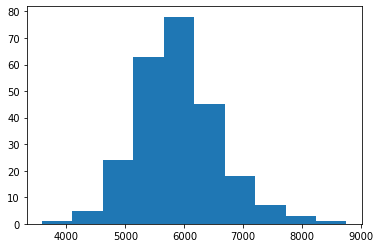

In [30]:
plt.hist(sample_sizes)

So, the above plot shows what the data looks like when the x_train and x_test samples are not stratified. I'm going to change the code to fix that so that we now get stratified samples. 

Let's see what that looks like:

(array([ 1.,  5., 21., 63., 82., 40., 21.,  8.,  3.,  1.]),
 array([3552., 4071., 4590., 5109., 5628., 6147., 6666., 7185., 7704.,
        8223., 8742.]),
 <BarContainer object of 10 artists>)

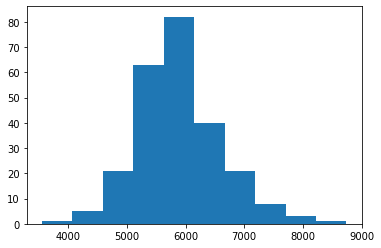

In [40]:
# Let's see how many tweets we are getting per date
sample_sizes = []
for d in x_train.dates:
    count_vecs = x_train.df[np.where(x_train.df[:, 0] == d)][:, 1]
    sample_sizes.append(len(count_vecs))
    
plt.hist(sample_sizes)

In [50]:
count = np.where(tweets.x[:, 0] == tweets.x[0, 0])

In [53]:
len(count[0])

5590

(array([ 1.,  5., 21., 63., 82., 40., 21.,  8.,  3.,  1.]),
 array([3552., 4071., 4590., 5109., 5628., 6147., 6666., 7185., 7704.,
        8223., 8742.]),
 <BarContainer object of 10 artists>)

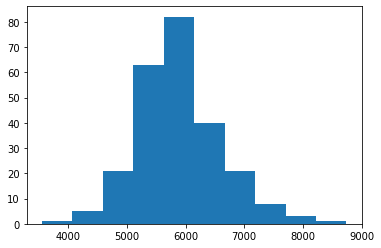

In [54]:
sample_sizes = []
for d in list(set(tweets.x[:,0])):
    count = np.where(tweets.x[:, 0] == d)[0]
    sample_sizes.append(len(count))
    
plt.hist(sample_sizes)

(array([ 1.,  5., 22., 62., 82., 40., 21.,  8.,  3.,  1.]),
 array([ 888. , 1017.8, 1147.6, 1277.4, 1407.2, 1537. , 1666.8, 1796.6,
        1926.4, 2056.2, 2186. ]),
 <BarContainer object of 10 artists>)

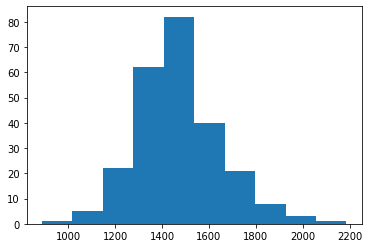

In [48]:
# Let's see how many tweets we are getting per date on the test set
sample_sizes = []
for d in x_test.dates:
    count_vecs = x_test.df[np.where(x_test.df[:, 0] == d)][:, 1]
    sample_sizes.append(len(count_vecs))
    
plt.hist(sample_sizes)

# On sampling.
Looks like the sampling is slightly fixed by stratifying, so we should keep that part in the code...however, we shouldn't expect that to make a big fix.

## Next up
Let's look at how we can validate the generation method of tweets.

In [ ]:
# Copied from above
tweets = Tweets(TWEET_PATH, max_df=0.01, agg_count=1000, sample_rate=50)

We will want to confirm that the generated tweets by the tweet dataset 
has the same mean as the actual mean of the count vector data.

To do this, I will need to take the count vector for all of a specific date, sum the rows, and divide by the number of samples, then multiply by 1000. This will give the expected value of the count vector, when sampling 1000 tweets at a time.

In [56]:
# Get the tweet dataset
date = x_train.dates[0]
count_vecs = x_train.df[np.where(x_train.df[:, 0] == date)][:, 1]

In [189]:
exp_value = count_vecs.sum() / len(count_vecs) * 1000

In [59]:
exp_value.toarray()

array([[0.        , 0.36791759, 0.        , ..., 0.55187638, 0.18395879,
        0.18395879]])

In [75]:
exp_value.max()

24.834437086092713

In [86]:
np.where(exp_value.toarray() > 0)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([   1,    3,    4, ..., 7361, 7362, 7363]))

In [77]:
# Get the indices to look at that should all have these values
indices = []
for i in range(0, 100):
    indices.append(i*245)

In [78]:
x_train_samples = [x_train[i] for i in indices]

In [97]:
xtrs = np.array(x_train_samples)[:,0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [110]:
xtrs.sum(axis=0)/100

array([0.  , 0.3 , 0.  , ..., 0.54, 0.15, 0.24], dtype=float32)

In [98]:
xtrs = np.array([t.numpy().flatten() for t in xtrs])

In [114]:
xtrs[:,1].std()

0.51961523

In [113]:
xtrs[:,1].mean()

0.3

Based on this initial analysis, it looks like we might be oversampling the high probability regions, and undersampling the low probability regions. This is likely going to hurt performance. How can we confirm this? Well, if this was the case, we should see a higher mean for the most often seen words, and a lower mean than the lesser seen words.

In [190]:
exp_value.toarray().flatten()[exp_value.toarray().argsort().flatten()[-10:]]

array([10.30169242, 10.8535688 , 11.22148639, 12.14128035, 12.32523915,
       12.32523915, 13.79690949, 14.71670346, 18.76379691, 24.83443709])

In [191]:
xtrs.sum(axis=0)[xtrs.sum(axis=0).argsort()[-10:]]/100

array([10.24, 10.98, 11.22, 12.23, 12.37, 12.6 , 13.76, 14.42, 17.06,
       25.75], dtype=float32)

So this actually doesn't look too bad...let's see how well the least seen words are. To do this, I will need to filter out the zero values.

In [159]:
np.where(exp_value.toarray() == 0)[1].sum()

10402790

In [157]:
np.where(xtrs.sum(axis=0) == 0)[0].sum()

10402790

Ok...well they have the same number of zeros. Let's look at the least seen words now.

In [217]:
exp_arr = exp_value.toarray().flatten()
non_zero = np.where(exp_arr > 0)[0]
exp_highest_100 = exp_arr[non_zero].argsort()[-100:]
exp_lowest_1000 = exp_arr[non_zero].argsort()[:1000]

In [203]:
len(non_zero)

4575

In [218]:
est_exp = xtrs.sum(axis=0)/100
non_zero = np.where(est_exp > 0)[0]
est_exp[non_zero]
est_highest_100 = est_exp[non_zero].argsort()[-100:]
est_lowest_1000 = est_exp[non_zero].argsort()[:1000]

How many of the least sampled values are in the least expected?

In [220]:
count = 0
for l in est_highest_100:
    if l in exp_highest_100:
        count += 1
print(f"{count} of the estimated highest 100 are in the expected highest 100")

count = 0
for l in est_lowest_1000:
    if l in exp_lowest_1000:
        count += 1
print(f"{count} of the estimated lowest 1000 are in the expected lowest")

97 of the estimated highest 100 are in the expected highest 100
585 of the estimated lowest 1000 are in the expected lowest


Guess the question is...how many times do we need to sample to get the right distribution?

(array([4.217e+03, 2.480e+02, 7.700e+01, 2.400e+01, 5.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.06 ,  2.629,  5.198,  7.767, 10.336, 12.905, 15.474, 18.043,
        20.612, 23.181, 25.75 ], dtype=float32),
 <BarContainer object of 10 artists>)

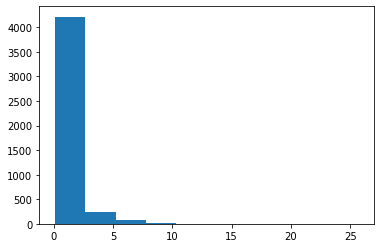

In [221]:
plt.hist(est_exp[non_zero])

(array([4.234e+03, 2.160e+02, 9.100e+01, 2.200e+01, 8.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.18395879,  2.64900662,  5.11405445,  7.57910228, 10.04415011,
        12.50919794, 14.97424577, 17.4392936 , 19.90434143, 22.36938926,
        24.83443709]),
 <BarContainer object of 10 artists>)

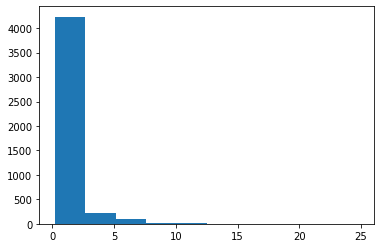

In [222]:
plt.hist(exp_arr[non_zero])

Let's sample WITHOUT replacement, and see how well this fixes the problem

In [225]:
tweets = Tweets(TWEET_PATH, max_df=0.01, agg_count=1000, sample_rate=50)

Loading in the data...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:48: DtypeWarning: Columns (0,1) have mixed types.Specify dtype option on import or set low_memory=False.


Cached file was found...loading lemmatized tweets from the cache.
Creating the count vector


In [226]:
x_train = tweets.load()
date = x_train.dates[0]
count_vecs = x_train.df[np.where(x_train.df[:, 0] == date)][:, 1]
len(count_vecs)

5436

In [227]:
exp_value = (count_vecs.sum() / len(count_vecs) * 1000).toarray().flatten()

In [327]:
indices = []
n = 1000
for i in range(0, n):
    indices.append(i*245)
    
x_train_samples = [x_train[i] for i in indices]

In [328]:
xtrs = np.array(x_train_samples)[:,0]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


In [352]:
exp_arr = exp_value
non_zero = np.where(exp_arr > 0)[0]
exp_highest_100 = exp_arr[non_zero].argsort()[-100:]
exp_lowest_2000 = exp_arr[non_zero].argsort()[:2000]
exp_lowest_1000 = exp_arr[non_zero].argsort()[:1000]
exp_lowest_500 = exp_arr[non_zero].argsort()[:500]

In [339]:
est_exp = (xtrs.sum(axis=0)/n).numpy().flatten()
non_zero = np.where(est_exp > 0)[0]
est_exp[non_zero]
est_highest_100 = est_exp[non_zero].argsort()[-100:]
est_lowest_1000 = est_exp[non_zero].argsort()[:2000]

In [330]:
count = 0
for l in est_highest_100:
    if l in exp_highest_100:
        count += 1
print(f"{count} of the estimated highest 100 are in the expected highest 100")

count = 0
for l in est_lowest_1000:
    if l in exp_lowest_1000:
        count += 1
print(f"{count} of the estimated lowest 1000 are in the expected lowest")

100 of the estimated highest 100 are in the expected highest 100
578 of the estimated lowest 1000 are in the expected lowest


In [356]:
sample_size = [10, 20, 30, 40, 50, 100, 500, 1000, 5000]

lowest_2000 = []
lowest_1000 = []
lowest_500 = []
highest_100 = []
for s in sample_size:
    indices = []
    for i in range(0, s):
        indices.append(i*245)
    x_train_samples = [x_train[i] for i in indices]
    xtrs = np.array(x_train_samples)[:,0]
    
    est_exp = (xtrs.sum(axis=0)/s).numpy().flatten()
    non_zero = np.where(est_exp > 0)[0]
    est_exp[non_zero]
    est_highest_100 = est_exp[non_zero].argsort()[-100:]
    est_lowest_2000 = est_exp[non_zero].argsort()[:2000]
    est_lowest_1000 = est_exp[non_zero].argsort()[:1000]
    est_lowest_500 = est_exp[non_zero].argsort()[:500]
    
    count = 0
    for l in exp_highest_100:
        if l in est_highest_100:
            count += 1
            
    highest_100.append(count/100)

    count = 0
    for l in exp_lowest_2000:
        if l in est_lowest_2000:
            count += 1
    lowest_2000.append(count/2000)
    
    count = 0
    for l in exp_lowest_1000:
        if l in est_lowest_1000:
            count += 1
            
    lowest_1000.append(count/1000)
    count = 0
    for l in exp_lowest_500:
        if l in est_lowest_500:
            count += 1
    
    lowest_500.append(count/500)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


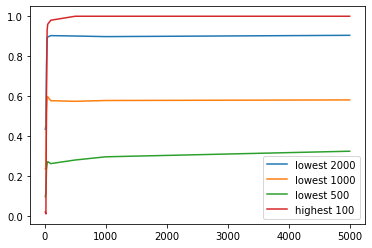

In [358]:
plt.plot(sample_size, lowest_2000, label="lowest 2000")
plt.plot(sample_size, lowest_1000, label="lowest 1000")
plt.plot(sample_size, lowest_500, label="lowest 500")
plt.plot(sample_size, highest_100, label="highest 100")
plt.legend()
plt.xlabel("Number of samples")
plt.ylabel("% of estimates matching expected distribution")
plt.show()

In [362]:
est_exp[non_zero][est_highest_100]

array([ 5.4844,  5.5012,  5.508 ,  5.5104,  5.519 ,  5.6704,  5.6764,
        5.6848,  5.6892,  5.6998,  5.7156,  5.7244,  5.7306,  5.7768,
        5.9136,  5.921 ,  5.9416,  6.0094,  6.0376,  6.0578,  6.0604,
        6.0612,  6.0964,  6.1006,  6.1034,  6.1036,  6.1204,  6.1276,
        6.2124,  6.2174,  6.2332,  6.2374,  6.2382,  6.2384,  6.248 ,
        6.2542,  6.2578,  6.2594,  6.268 ,  6.3192,  6.3686,  6.4412,
        6.4672,  6.4882,  6.5992,  6.6094,  6.6244,  6.6282,  6.6582,
        6.7532,  6.7714,  6.779 ,  6.789 ,  6.845 ,  6.9782,  6.9952,
        7.1546,  7.1786,  7.2074,  7.2372,  7.2376,  7.3262,  7.3516,
        7.4906,  7.5662,  7.5708,  7.7156,  7.8914,  7.9266,  7.9962,
        8.0614,  8.0616,  8.1066,  8.1372,  8.242 ,  8.429 ,  8.4624,
        8.5014,  8.5894,  8.6404,  8.7768,  8.8246,  9.012 ,  9.1698,
        9.4074,  9.4354,  9.5534,  9.9208, 10.1382, 10.1394, 10.2682,
       10.8766, 11.3184, 12.1104, 12.2812, 12.3726, 13.867 , 14.8502,
       18.7704, 24.8

In [364]:
exp_arr[non_zero][est_lowest_2000]

array([0.18395879, 0.18395879, 0.18395879, ..., 0.36791759, 0.36791759,
       0.36791759])

In [365]:
len(count_vecs)

5436

In [366]:
1/5436*1000

0.18395879323031641

In [369]:
# The number of counts that appear once or zero
len(exp_arr[exp_arr < 0.184])

4495

In [374]:
# Number of words only appearing once
(exp_arr[non_zero] < 0.184).sum()

1706

In [375]:
# Number of words appearing zero times
(exp_arr == 0).sum()

2789

In [370]:
# Number of words appearing more than once
len(exp_arr[exp_arr > 0.184])

2869

In [371]:
len(exp_arr)

7364

In [372]:
len(exp_arr[exp_arr < 0.184])+len(exp_arr[exp_arr > 0.184])

7364

(array([6.982e+03, 2.420e+02, 1.030e+02, 2.400e+01, 9.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([ 0.        ,  2.48344371,  4.96688742,  7.45033113,  9.93377483,
        12.41721854, 14.90066225, 17.38410596, 19.86754967, 22.35099338,
        24.83443709]),
 <BarContainer object of 10 artists>)

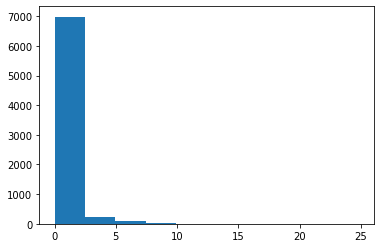

In [376]:
plt.hist(exp_arr)

# EUREKA
So, after all that, it looks like the issue is because a TON of words are only appearing once on this date, which messes with the distribution.

To get rid of this problem then, it looks like oversampling should be done to get tons of examples both with these words and without these words. If we don't oversample, our model will overfit to these one off occurrences that just so happens to occur.

In [9]:
train_loader = DataLoader(x_train, batch_size=128)
test_loader = DataLoader(x_test, batch_size=128)

In [10]:
class VAE(nn.Module):
    """
    Should rename -- PFA for Poisson Factor Analysis
    """

    def __init__(self, vocab, num_components=20, prior_mean=1, prior_logvar=0):
        """
        Inputs
        --------
        vocab<int>: the size of the vocabulary

        This model only has the variational layer, then the output
        to the reconstruction. At this point, there are no hidden layers.
        """
        super().__init__()
        self.num_components = num_components

        self.prior_mean = torch.tensor(prior_mean)
        self.prior_logvar = torch.tensor(prior_logvar)

        # Add in these layers to create a nonlinear function
        # from the words to the latent space.
        self.fc1 = nn.Linear(vocab, 1000)
        self.fc21 = nn.Linear(1000, num_components)
        self.fc22 = nn.Linear(1000, num_components)
#         self.enc_logvar = nn.Linear(vocab, num_components, bias=False)
#         self.enc_mu = nn.Linear(vocab, num_components, bias=False)
        self.W_tilde = torch.rand(num_components, vocab, requires_grad=True)
        self.pois_nll = nn.PoissonNLLLoss(log_input=False)
        self.softplus = nn.Softplus()

        self.beta = nn.Linear(num_components, num_components, bias=False)
        self.beta1 = nn.Linear(num_components, 1, bias=True)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def forward(self, x):
#         mu = self.enc_mu(x)
#         logvar = self.enc_logvar(x)
        
        mu, logvar = self.encode(x)

        s_tilde = self.reparameterize(mu, logvar)

        s = self.softplus(s_tilde)
        W = self.softplus(self.W_tilde)

        # Predict y using the first node from s
        y_hat = self.beta1(F.relu(self.beta(s)))

        return s, W, mu, logvar, y_hat

    def get_topic_dist(self, x):
        """
        When it comes to looking at the norm, we want to calculate the
        probability that a certain sample belongs to each topic.
        """
        s, _ = self.encode(x)
        W = self.parameters()  # TODO - figure out which parameters to add.
        norm = torch.norm(s @ W, p=1)  # Return the L1 norm
        # TODO -- add in the multinomial distribution.

        # TODO - need to calculate elementwise product.
        return s @ W / norm

    def _kl_divergence(self, mean, logvar):
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114
        # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        # BUT...
        # Code extended to handle a more informative prior
        # Referencing this derivation found here:
        # https://stanford.edu/~jduchi/projects/general_notes.pdf
        # Assume diagonal matrices for variance
        KLD = -0.5 * torch.sum(
            1
            + logvar
            - self.prior_logvar
            - (mean - self.prior_mean) ** 2 / self.prior_logvar.exp()
            - logvar.exp() / self.prior_logvar.exp()
        )

        return KLD

    def loss_function(self, recon_x, x, mu, logvar, y, y_hat):
        KLD = self._kl_divergence(mu, logvar)
        PNLL = self.pois_nll(recon_x, x)
        # This will disproportionately weight higher values of y
        MSE = (y - y_hat).pow(2).mean()
        return PNLL, MSE, KLD

    @torch.no_grad()
    def reconstruct(self, X):
        s, W, mu, logvar = self.forward(X)

        return s @ W

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda")

In [29]:
model = VAE(tweets.vocab_size, num_components=1000, prior_mean=1, prior_logvar=0)
model.to(device)

EPOCHS = 100
print_rate = 10
optimizer = optim.Adam(model.parameters(), lr=1e-5)

In [13]:
loss_results = {
        "train": {"pnll": [], "mse": [], "kld": [], "total": []},
        "val": {"pnll": [], "mse": [], "kld": [], "total": []},
    }

In [30]:
for epoch in range(EPOCHS):
    epoch_train_loss = 0
    epoch_test_loss = 0
    # Run method on training
    model.train()
    avg_pnll = 0
    avg_mse = 0
    avg_kld = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        # Add training data to GPU
        data = data.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        s, W, mu, logvar, y_hat = model(data)
        s = s.to(device)
        W = W.to(device)
        y_hat = y_hat.to(device)
        recon_batch = s @ W  # Calculate the reconstructed matrix
        recon_batch = recon_batch.to(device)
        mu = mu.to(device)
        logvar = logvar.to(device)
        PNLL, MSE, KLD = model.loss_function(
            recon_batch, data, mu, logvar, y, y_hat
        )

        loss = torch.mean(MSE )#+ 0.00001*PNLL + 0.000001*KLD)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            avg_pnll += torch.mean(PNLL).item()
            avg_mse += torch.mean(MSE).item()
            avg_kld += torch.mean(KLD).item()
        epoch_train_loss += loss.item()

        if batch_idx % print_rate == 0:
            print(
                "Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print(
        "===> Epoch: {} Average Loss: {:.4f}".format(
            epoch, epoch_train_loss / len(train_loader.dataset)
        )
    )
    print("PNLL: ", avg_pnll / batch_idx)
    print("MSE: ", avg_mse / batch_idx)
    print("KLD: ", avg_kld / batch_idx)

Train epoch: 0 [0/9800 (0%)]	Loss: 0.013342
Train epoch: 0 [1280/9800 (13%)]	Loss: 0.001311
Train epoch: 0 [2560/9800 (26%)]	Loss: 0.001141
Train epoch: 0 [3840/9800 (39%)]	Loss: 0.000765
Train epoch: 0 [5120/9800 (52%)]	Loss: 0.000551
Train epoch: 0 [6400/9800 (65%)]	Loss: 0.000469
Train epoch: 0 [7680/9800 (78%)]	Loss: 0.000439
Train epoch: 0 [8960/9800 (91%)]	Loss: 0.000481
===> Epoch: 0 Average Loss: 0.0014
PNLL:  816.4378493459601
MSE:  0.18486817239930756
KLD:  75941.02395148027
Train epoch: 1 [0/9800 (0%)]	Loss: 0.000462
Train epoch: 1 [1280/9800 (13%)]	Loss: 0.000437
Train epoch: 1 [2560/9800 (26%)]	Loss: 0.000498
Train epoch: 1 [3840/9800 (39%)]	Loss: 0.000552
Train epoch: 1 [5120/9800 (52%)]	Loss: 0.000462
Train epoch: 1 [6400/9800 (65%)]	Loss: 0.000422
Train epoch: 1 [7680/9800 (78%)]	Loss: 0.000368
Train epoch: 1 [8960/9800 (91%)]	Loss: 0.000484
===> Epoch: 1 Average Loss: 0.0005
PNLL:  808.0621281674033
MSE:  0.06032053969408337
KLD:  77163.72769325657
Train epoch: 2 [0/98

Train epoch: 16 [8960/9800 (91%)]	Loss: 0.000384
===> Epoch: 16 Average Loss: 0.0004
PNLL:  692.5684517308285
MSE:  0.04730771629041747
KLD:  231094.51110197368
Train epoch: 17 [0/9800 (0%)]	Loss: 0.000353
Train epoch: 17 [1280/9800 (13%)]	Loss: 0.000295
Train epoch: 17 [2560/9800 (26%)]	Loss: 0.000385
Train epoch: 17 [3840/9800 (39%)]	Loss: 0.000440
Train epoch: 17 [5120/9800 (52%)]	Loss: 0.000359
Train epoch: 17 [6400/9800 (65%)]	Loss: 0.000296
Train epoch: 17 [7680/9800 (78%)]	Loss: 0.000292
Train epoch: 17 [8960/9800 (91%)]	Loss: 0.000381
===> Epoch: 17 Average Loss: 0.0004
PNLL:  688.0264948794717
MSE:  0.04717904089116737
KLD:  242945.26624177632
Train epoch: 18 [0/9800 (0%)]	Loss: 0.000353
Train epoch: 18 [1280/9800 (13%)]	Loss: 0.000295
Train epoch: 18 [2560/9800 (26%)]	Loss: 0.000385
Train epoch: 18 [3840/9800 (39%)]	Loss: 0.000439
Train epoch: 18 [5120/9800 (52%)]	Loss: 0.000358
Train epoch: 18 [6400/9800 (65%)]	Loss: 0.000295
Train epoch: 18 [7680/9800 (78%)]	Loss: 0.000291


Train epoch: 33 [1280/9800 (13%)]	Loss: 0.000289
Train epoch: 33 [2560/9800 (26%)]	Loss: 0.000378
Train epoch: 33 [3840/9800 (39%)]	Loss: 0.000435
Train epoch: 33 [5120/9800 (52%)]	Loss: 0.000354
Train epoch: 33 [6400/9800 (65%)]	Loss: 0.000289
Train epoch: 33 [7680/9800 (78%)]	Loss: 0.000286
Train epoch: 33 [8960/9800 (91%)]	Loss: 0.000377
===> Epoch: 33 Average Loss: 0.0004
PNLL:  640.2648516203228
MSE:  0.04642450005600327
KLD:  383982.1837993421
Train epoch: 34 [0/9800 (0%)]	Loss: 0.000348
Train epoch: 34 [1280/9800 (13%)]	Loss: 0.000289
Train epoch: 34 [2560/9800 (26%)]	Loss: 0.000378
Train epoch: 34 [3840/9800 (39%)]	Loss: 0.000435
Train epoch: 34 [5120/9800 (52%)]	Loss: 0.000354
Train epoch: 34 [6400/9800 (65%)]	Loss: 0.000288
Train epoch: 34 [7680/9800 (78%)]	Loss: 0.000287
Train epoch: 34 [8960/9800 (91%)]	Loss: 0.000377
===> Epoch: 34 Average Loss: 0.0004
PNLL:  638.3986342580695
MSE:  0.04640994760158815
KLD:  390708.7263569079
Train epoch: 35 [0/9800 (0%)]	Loss: 0.000348
Tr

Train epoch: 49 [7680/9800 (78%)]	Loss: 0.000286
Train epoch: 49 [8960/9800 (91%)]	Loss: 0.000376
===> Epoch: 49 Average Loss: 0.0004
PNLL:  617.4864461798417
MSE:  0.04628121872481547
KLD:  473936.9333881579
Train epoch: 50 [0/9800 (0%)]	Loss: 0.000346
Train epoch: 50 [1280/9800 (13%)]	Loss: 0.000288
Train epoch: 50 [2560/9800 (26%)]	Loss: 0.000378
Train epoch: 50 [3840/9800 (39%)]	Loss: 0.000434
Train epoch: 50 [5120/9800 (52%)]	Loss: 0.000353
Train epoch: 50 [6400/9800 (65%)]	Loss: 0.000287
Train epoch: 50 [7680/9800 (78%)]	Loss: 0.000286
Train epoch: 50 [8960/9800 (91%)]	Loss: 0.000376
===> Epoch: 50 Average Loss: 0.0004
PNLL:  616.2895580090975
MSE:  0.04627267795761949
KLD:  478785.69407894736
Train epoch: 51 [0/9800 (0%)]	Loss: 0.000347
Train epoch: 51 [1280/9800 (13%)]	Loss: 0.000288
Train epoch: 51 [2560/9800 (26%)]	Loss: 0.000378
Train epoch: 51 [3840/9800 (39%)]	Loss: 0.000434
Train epoch: 51 [5120/9800 (52%)]	Loss: 0.000354
Train epoch: 51 [6400/9800 (65%)]	Loss: 0.000287
T

Train epoch: 66 [1280/9800 (13%)]	Loss: 0.000287
Train epoch: 66 [2560/9800 (26%)]	Loss: 0.000377
Train epoch: 66 [3840/9800 (39%)]	Loss: 0.000433
Train epoch: 66 [5120/9800 (52%)]	Loss: 0.000353
Train epoch: 66 [6400/9800 (65%)]	Loss: 0.000286
Train epoch: 66 [7680/9800 (78%)]	Loss: 0.000285
Train epoch: 66 [8960/9800 (91%)]	Loss: 0.000375
===> Epoch: 66 Average Loss: 0.0004
PNLL:  599.2624270790502
MSE:  0.046211157827393004
KLD:  550248.8585526316
Train epoch: 67 [0/9800 (0%)]	Loss: 0.000346
Train epoch: 67 [1280/9800 (13%)]	Loss: 0.000287
Train epoch: 67 [2560/9800 (26%)]	Loss: 0.000377
Train epoch: 67 [3840/9800 (39%)]	Loss: 0.000433
Train epoch: 67 [5120/9800 (52%)]	Loss: 0.000353
Train epoch: 67 [6400/9800 (65%)]	Loss: 0.000286
Train epoch: 67 [7680/9800 (78%)]	Loss: 0.000285
Train epoch: 67 [8960/9800 (91%)]	Loss: 0.000375
===> Epoch: 67 Average Loss: 0.0004
PNLL:  598.3406604967619
MSE:  0.04620883128556766
KLD:  554301.0649671053
Train epoch: 68 [0/9800 (0%)]	Loss: 0.000346
T

Train epoch: 82 [7680/9800 (78%)]	Loss: 0.000286
Train epoch: 82 [8960/9800 (91%)]	Loss: 0.000375
===> Epoch: 82 Average Loss: 0.0004
PNLL:  528.7516214471115
MSE:  0.046321894924499486
KLD:  584856.9185855263
Train epoch: 83 [0/9800 (0%)]	Loss: 0.000352
Train epoch: 83 [1280/9800 (13%)]	Loss: 0.000291
Train epoch: 83 [2560/9800 (26%)]	Loss: 0.000377
Train epoch: 83 [3840/9800 (39%)]	Loss: 0.000434
Train epoch: 83 [5120/9800 (52%)]	Loss: 0.000354
Train epoch: 83 [6400/9800 (65%)]	Loss: 0.000286
Train epoch: 83 [7680/9800 (78%)]	Loss: 0.000285
Train epoch: 83 [8960/9800 (91%)]	Loss: 0.000375
===> Epoch: 83 Average Loss: 0.0004
PNLL:  524.3465752852591
MSE:  0.04633094757599266
KLD:  587609.0394736842
Train epoch: 84 [0/9800 (0%)]	Loss: 0.000350
Train epoch: 84 [1280/9800 (13%)]	Loss: 0.000292
Train epoch: 84 [2560/9800 (26%)]	Loss: 0.000378
Train epoch: 84 [3840/9800 (39%)]	Loss: 0.000434
Train epoch: 84 [5120/9800 (52%)]	Loss: 0.000354
Train epoch: 84 [6400/9800 (65%)]	Loss: 0.000286
T

Train epoch: 99 [1280/9800 (13%)]	Loss: 0.000290
Train epoch: 99 [2560/9800 (26%)]	Loss: 0.000380
Train epoch: 99 [3840/9800 (39%)]	Loss: 0.000433
Train epoch: 99 [5120/9800 (52%)]	Loss: 0.000353
Train epoch: 99 [6400/9800 (65%)]	Loss: 0.000286
Train epoch: 99 [7680/9800 (78%)]	Loss: 0.000285
Train epoch: 99 [8960/9800 (91%)]	Loss: 0.000375
===> Epoch: 99 Average Loss: 0.0004
PNLL:  453.62384233976667
MSE:  0.046289389413830484
KLD:  626233.8824013158


In [15]:
len(train_loader.dataset)

9800

In [ ]:
plt.plot(range(EPOCHS), loss)

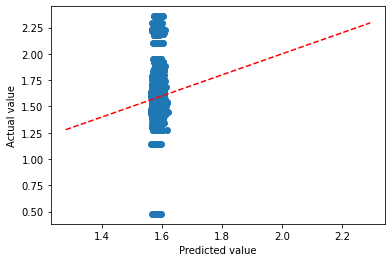

In [31]:
y_vals = []
y_preds = []
for x, y in train_loader:
    x = x.to(device)
    y_vals.append(y)
    s, W, mu, logvar, y_hat = model(x)
    y_preds.append(y_hat)

y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y), max(y), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

In [120]:
len(y_vals)

2450

In [100]:
y_vals

tensor([1.3010, 1.7160, 1.7324,  ..., 1.5563, 1.5441, 1.7243])

In [102]:
y_preds.flatten()

tensor([1.0444, 0.7814, 0.8331,  ..., 1.0684, 0.7575, 0.7051])

In [135]:
from sklearn.metrics import r2_score

r2_score(y_vals, y_preds.flatten())

-0.010582941580409733

In [136]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_vals, y_preds.flatten())

0.046129625

In [137]:
np.corrcoef(y_vals, y_preds.flatten())

array([[1.        , 0.03892555],
       [0.03892555, 1.        ]])

In [17]:
model.eval()
log_vals = []
mu_vals = []
for x, y in train_loader:
    x = x.to(device)
    s, W, mu, logvar, y_hat = model(x)
    log_vals.append(logvar)
    mu_vals.append(mu)

In [18]:
mu_vals = torch.cat(mu_vals).detach().cpu().numpy()

In [19]:
log_vals = torch.cat(log_vals).detach().cpu().numpy()

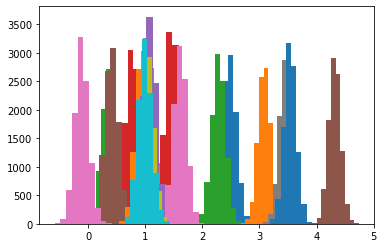

In [22]:
for i in range(20):
    plt.hist(mu_vals[:,0, i])

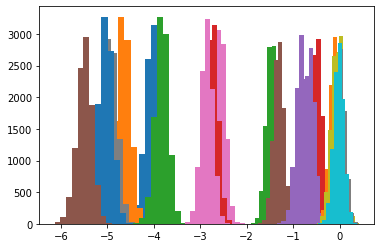

In [23]:
for i in range(20):
    plt.hist(log_vals[:,0, i])

In [83]:
n = 2
with torch.no_grad():
    for yh, y_a in zip(y_hat, y):
        print(f'{yh.detach().item()} | {y_a} | {(yh-y_a).pow(n)}')

    print()
    print((yh-y_a).pow(n).mean())

1.364013671875 | 0.4771212637424469 | tensor([[0.7866]], device='cuda:0')
1.3105111122131348 | 1.556302547454834 | tensor([[0.0604]], device='cuda:0')
1.7251465320587158 | 1.6720978021621704 | tensor([[0.0028]], device='cuda:0')
1.75349760055542 | 1.6127839088439941 | tensor([[0.0198]], device='cuda:0')
1.6532137393951416 | 1.4471579790115356 | tensor([[0.0425]], device='cuda:0')
1.3493053913116455 | 1.3617278337478638 | tensor([[0.0002]], device='cuda:0')
1.480534553527832 | 1.3424227237701416 | tensor([[0.0191]], device='cuda:0')
1.259460687637329 | 1.6434526443481445 | tensor([[0.1474]], device='cuda:0')
1.2042808532714844 | 1.6020599603652954 | tensor([[0.1582]], device='cuda:0')
1.8668303489685059 | 1.9493900537490845 | tensor([[0.0068]], device='cuda:0')
1.4541853666305542 | 2.2355284690856934 | tensor([[0.6105]], device='cuda:0')
1.4478633403778076 | 1.3424227237701416 | tensor([[0.0111]], device='cuda:0')
1.301031470298767 | 1.5440680980682373 | tensor([[0.0591]], device='cuda:

In [115]:
# Capture testing performance.
model.eval()
frobenius_norms = []
poisson = []
mean_squared_error = []
kl_divergence = []
avg_pnll = 0
avg_mse = 0
avg_kld = 0
with torch.no_grad():
    for batch_idx, (data, y) in enumerate(test_loader):
        # Add to GPU
        data = data.to(device)
        y = y.to(device)
        s, W, mu, logvar, y_hat = model(data)
        W = W.to(device)
        recon_batch = s @ W
        PNLL, MSE, KLD = model.loss_function(
            recon_batch, data, mu, logvar, y, y_hat
        )
        loss = torch.mean(MSE)#PNLL + MSE + 0.1 * KLD)
        avg_pnll += torch.mean(PNLL).item()
        avg_mse += torch.mean(MSE).item()
        avg_kld += torch.mean(KLD).item()
        epoch_test_loss += loss.item()

        # Calculate frobenius norm of the reconstructed matrix
        frobenius_norms.append(
            torch.norm(recon_batch - data, p="fro", dim=2).mean().item()
        )
        mean_squared_error.append(MSE)
        kl_divergence.append(KLD)

avg_mse /= len(test_loader.dataset)
avg_pnll /= len(test_loader.dataset)
avg_kld /= len(test_loader.dataset)
epoch_test_loss /= len(test_loader.dataset)

# # Append results to the json
# loss["val"]["pnll"].append(avg_pnll)
# loss["val"]["mse"].append(avg_mse)
# loss["val"]["kld"].append(avg_kld)
# loss["val"]["total"].append(epoch_test_loss)

avg_f_norm = sum(frobenius_norms) / len(frobenius_norms)
print("===> Test set loss: {:.4f}".format(epoch_test_loss))
# Print frobenius norm
print("======> Test set frobenius norm: {:.4f}".format(avg_f_norm))
print("======> Test set mean squared error: {:.4f}".format(avg_mse))
print("======> Test set kl divergence: {:.4f}".format(avg_kld))
print("======> Test set poisson: {:.4f}".format(avg_pnll))

===> Test set loss: 0.0004
======> Test set frobenius norm: 902.3006
======> Test set mean squared error: 0.0004
======> Test set kl divergence: 8.2761
======> Test set poisson: 0.0811


In [85]:
import matplotlib.pyplot as plt

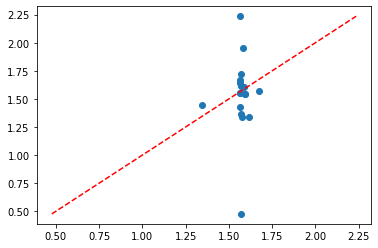

In [116]:
y_hat = y_hat.to('cpu').detach()
y = y.to('cpu').detach()
perfect = np.linspace(min(y), max(y), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.scatter(y_hat, y)

In [117]:
y_vals = []
y_preds = []
for x, y in test_loader:
    x = x.to(device)
    y_vals.append(y)
    s, W, mu, logvar, y_hat = model(x)
    y_preds.append(y_hat)


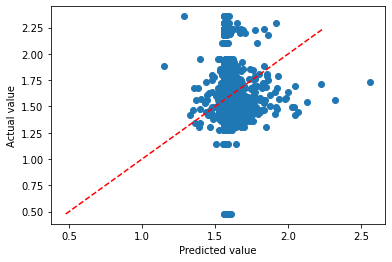

In [118]:
y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y), max(y), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

# let's see if we can simply overfit a model...why can't we get this model to be good???

In [117]:
class overfit(nn.Module):
    """
    I'm creating this model to see if we can just overfit a model to
    predict the AQI on a given day using count vectors.
    """
    def __init__(self, vocab):
        super().__init__()
        self.fc1 = nn.Linear(vocab, 5000, bias=True)
        self.fc2 = nn.Linear(5000, 2000, bias=True)
        self.fc3 = nn.Linear(2000, 1000, bias=True)
        self.fc4 = nn.Linear(1000, 1)
        
    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        h3 = F.relu(self.fc3(h2))
        h4 = self.fc4(h3)
        
        return h4
    
    def loss_function(self, y, y_hat):
        mse = (y-y_hat).pow(2).mean()
        return mse
    

In [118]:
model = overfit(tweets.vocab_size)
model.to(device)

EPOCHS = 100
print_rate = 10
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [119]:
for epoch in range(EPOCHS):
    epoch_train_loss = 0
    epoch_test_loss = 0
    # Run method on training
    model.train()
    avg_mse = 0
    for batch_idx, (data, y) in enumerate(train_loader):
        # Add training data to GPU
        data = data.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        y_hat = model(data)
        y_hat = y_hat.to(device)
        loss = model.loss_function(y, y_hat)
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            avg_mse += torch.mean(MSE).item()
        epoch_train_loss += loss.item()

        if batch_idx % print_rate == 0:
            print(
                "Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(train_loader.dataset),
                    100.0 * batch_idx / len(train_loader),
                    loss.item() / len(data),
                )
            )
    print(
        "===> Epoch: {} Average Loss: {:.4f}".format(
            epoch, epoch_train_loss / len(train_loader.dataset)
        )
    )
    print("MSE: ", avg_mse / batch_idx)

Train epoch: 0 [0/9800 (0%)]	Loss: 0.021266
Train epoch: 0 [1280/9800 (13%)]	Loss: 0.002524
Train epoch: 0 [2560/9800 (26%)]	Loss: 0.000430
Train epoch: 0 [3840/9800 (39%)]	Loss: 0.000483
Train epoch: 0 [5120/9800 (52%)]	Loss: 0.000404
Train epoch: 0 [6400/9800 (65%)]	Loss: 0.000336
Train epoch: 0 [7680/9800 (78%)]	Loss: 0.000333
Train epoch: 0 [8960/9800 (91%)]	Loss: 0.000407
===> Epoch: 0 Average Loss: 0.5964
MSE:  0.045076619735673853
Train epoch: 1 [0/9800 (0%)]	Loss: 0.000431
Train epoch: 1 [1280/9800 (13%)]	Loss: 0.000314
Train epoch: 1 [2560/9800 (26%)]	Loss: 0.000426
Train epoch: 1 [3840/9800 (39%)]	Loss: 0.000462
Train epoch: 1 [5120/9800 (52%)]	Loss: 0.000382
Train epoch: 1 [6400/9800 (65%)]	Loss: 0.000323
Train epoch: 1 [7680/9800 (78%)]	Loss: 0.000312
Train epoch: 1 [8960/9800 (91%)]	Loss: 0.000399
===> Epoch: 1 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 2 [0/9800 (0%)]	Loss: 0.000372
Train epoch: 2 [1280/9800 (13%)]	Loss: 0.000322
Train epoch: 2 [2560/980

Train epoch: 18 [5120/9800 (52%)]	Loss: 0.000422
Train epoch: 18 [6400/9800 (65%)]	Loss: 0.000450
Train epoch: 18 [7680/9800 (78%)]	Loss: 0.000342
Train epoch: 18 [8960/9800 (91%)]	Loss: 0.000682
===> Epoch: 18 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 19 [0/9800 (0%)]	Loss: 0.000460
Train epoch: 19 [1280/9800 (13%)]	Loss: 0.000298
Train epoch: 19 [2560/9800 (26%)]	Loss: 0.000423
Train epoch: 19 [3840/9800 (39%)]	Loss: 0.000463
Train epoch: 19 [5120/9800 (52%)]	Loss: 0.000463
Train epoch: 19 [6400/9800 (65%)]	Loss: 0.000304
Train epoch: 19 [7680/9800 (78%)]	Loss: 0.000314
Train epoch: 19 [8960/9800 (91%)]	Loss: 0.000385
===> Epoch: 19 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 20 [0/9800 (0%)]	Loss: 0.000378
Train epoch: 20 [1280/9800 (13%)]	Loss: 0.000296
Train epoch: 20 [2560/9800 (26%)]	Loss: 0.000425
Train epoch: 20 [3840/9800 (39%)]	Loss: 0.000440
Train epoch: 20 [5120/9800 (52%)]	Loss: 0.000372
Train epoch: 20 [6400/9800 (65%)]	Loss: 0.000297


Train epoch: 36 [7680/9800 (78%)]	Loss: 0.000312
Train epoch: 36 [8960/9800 (91%)]	Loss: 0.000381
===> Epoch: 36 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 37 [0/9800 (0%)]	Loss: 0.000352
Train epoch: 37 [1280/9800 (13%)]	Loss: 0.000291
Train epoch: 37 [2560/9800 (26%)]	Loss: 0.000382
Train epoch: 37 [3840/9800 (39%)]	Loss: 0.000436
Train epoch: 37 [5120/9800 (52%)]	Loss: 0.000370
Train epoch: 37 [6400/9800 (65%)]	Loss: 0.000337
Train epoch: 37 [7680/9800 (78%)]	Loss: 0.000317
Train epoch: 37 [8960/9800 (91%)]	Loss: 0.000389
===> Epoch: 37 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 38 [0/9800 (0%)]	Loss: 0.000350
Train epoch: 38 [1280/9800 (13%)]	Loss: 0.000291
Train epoch: 38 [2560/9800 (26%)]	Loss: 0.000382
Train epoch: 38 [3840/9800 (39%)]	Loss: 0.000437
Train epoch: 38 [5120/9800 (52%)]	Loss: 0.000362
Train epoch: 38 [6400/9800 (65%)]	Loss: 0.000322
Train epoch: 38 [7680/9800 (78%)]	Loss: 0.000314
Train epoch: 38 [8960/9800 (91%)]	Loss: 0.000399


===> Epoch: 54 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 55 [0/9800 (0%)]	Loss: 0.000350
Train epoch: 55 [1280/9800 (13%)]	Loss: 0.000307
Train epoch: 55 [2560/9800 (26%)]	Loss: 0.000389
Train epoch: 55 [3840/9800 (39%)]	Loss: 0.000463
Train epoch: 55 [5120/9800 (52%)]	Loss: 0.000370
Train epoch: 55 [6400/9800 (65%)]	Loss: 0.000302
Train epoch: 55 [7680/9800 (78%)]	Loss: 0.000305
Train epoch: 55 [8960/9800 (91%)]	Loss: 0.000377
===> Epoch: 55 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 56 [0/9800 (0%)]	Loss: 0.000350
Train epoch: 56 [1280/9800 (13%)]	Loss: 0.000301
Train epoch: 56 [2560/9800 (26%)]	Loss: 0.000386
Train epoch: 56 [3840/9800 (39%)]	Loss: 0.000460
Train epoch: 56 [5120/9800 (52%)]	Loss: 0.000366
Train epoch: 56 [6400/9800 (65%)]	Loss: 0.000301
Train epoch: 56 [7680/9800 (78%)]	Loss: 0.000300
Train epoch: 56 [8960/9800 (91%)]	Loss: 0.000377
===> Epoch: 56 Average Loss: 0.0004
MSE:  0.045076619735673853
Train epoch: 57 [0/9800 (0%)]	Loss:

KeyboardInterrupt: 

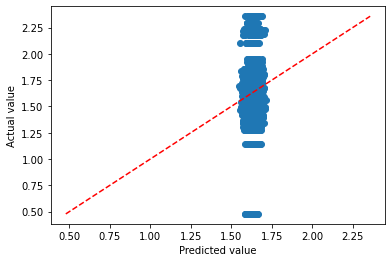

In [116]:
y_vals = []
y_preds = []
for x, y in train_loader:
    x = x.to(device)
    y_vals.append(y)
    y_hat = model(x)
    y_preds.append(y_hat)

y_vals = torch.cat(y_vals).cpu().detach()
y_preds = torch.cat(y_preds).cpu().detach()
perfect = np.linspace(min(y_vals), max(y_vals), 100)
plt.plot(perfect, perfect, '--', color='red')
plt.xlabel("Predicted value")
plt.ylabel("Actual value")
plt.scatter(y_preds, y_vals)

In [50]:
df = tweets.x

In [78]:
x_train_new = []
y_train_new = []
for x, y in train_loader:
    x_train_new.append(x.detach().cpu().numpy().reshape(-1, 7244))
    y_train_new.append(y.detach().cpu().numpy().reshape(-1,1))

In [87]:
x_train_new = np.concatenate(x_train_new)
y_train_new = np.concatenate(y_train_new)

In [88]:
from sklearn.neighbors import KNeighborsRegressor

In [89]:
model = KNeighborsRegressor(n_neighbors=5).fit(x_train_new, y_train_new)

In [91]:
y_pred = model.predict(x_train_new)

In [92]:
model.score(x_train_new, y_train_new)

0.9999999999999606

In [93]:
x_test_new = []
y_test_new = []
for x, y in test_loader:
    x_test_new.append(x.detach().cpu().numpy().reshape(-1, 7244))
    y_test_new.append(y.detach().cpu().numpy().reshape(-1,1))

In [96]:
x_test_new = np.concatenate(x_test_new)
y_test_new = np.concatenate(y_test_new)

In [97]:
model.score(x_test_new, y_test_new)

0.7806294117597303

In [99]:
y_preds = model.predict(x_test_new)

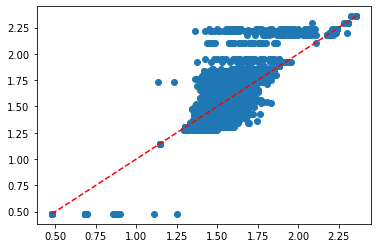

In [100]:
perfect = np.linspace(min(y_test_new), max(y_test_new), 100)
plt.scatter(y_preds, y_test_new)

plt.plot(perfect, perfect, '--', color='red')
plt.show()
